In [11]:
import torch

x_tensor shape: torch.Size([1000, 1, 10, 10])
y_tensor shape: torch.Size([1000])
train_idx length: 800
val_idx length: 200


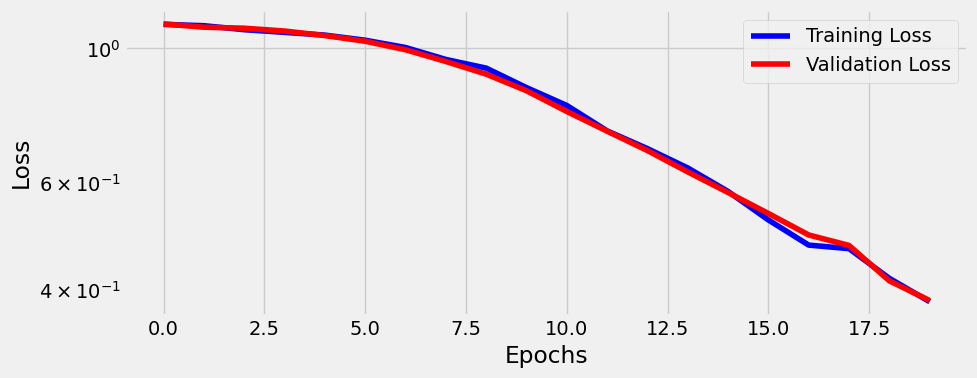

In [12]:
# Common Libraries
import random 
import numpy as np
import torch
import matplotlib.pyplot  as plt

# Image Augmentation 
from PIL import Image 
from image_classification import generate_dataset 

# Previously Defined Functions and Classes
from v1 import StepByStep 
from torch.utils.data import Dataset , DataLoader

# Data Utilities
from helpers import index_splitter, make_balanced_sampler
from torchvision.transforms.v2 import Compose,Normalize

#PyTorch Optimization and Loss Functions
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


#data geneartion 


images, labels= generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

############## data preparation ######################### 
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y= y
        self.transform= transform

    def __getitem__(self, index):
        x= self.x[index]

        if self.transform:
            x=self.transform(x)

        return x, self.y[index] 

    def __len__(self):
        return len(self.x)
    

####################### data preparationn ############################################
from helpers import index_splitter, make_balanced_sampler
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize
import torch

# Convert numpy arrays to PyTorch tensors and normalize pixel values
x_tensor = torch.as_tensor(images / 255.0).float()
y_tensor = torch.as_tensor(labels).long()

# Check tensor shapes
print(f"x_tensor shape: {x_tensor.shape}")
print(f"y_tensor shape: {y_tensor.shape}")

# Split indices into training and validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Ensure indices are valid
print(f"train_idx length: {len(train_idx)}")
print(f"val_idx length: {len(val_idx)}")

# Apply the split to tensors
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Define normalization transforms for training and validation sets
transform = Compose([Normalize(mean=(0.5,), std=(0.5,))])

# Create datasets with transformations applied
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=transform)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=transform)

# Create a weighted random sampler to handle class imbalance
sampler = make_balanced_sampler(y_train_tensor)

# Create data loaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)



####################### model configuration ##########################################################
torch.manual_seed(42)
model_cnn1= nn.Sequential()



# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels= 10
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))    

# model_cnn1.add_module('conv2', nn.Conv2d(in_ch))
# Flattening: n_channels * 4 * 4
model_cnn1.add_module('flatten', nn.Flatten())

## classification 
#hidden layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
#output layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))



lr= 0.01
multi_loss_fn= nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1= optim.SGD(model_cnn1.parameters(),lr=lr)

################# model training #########################
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn,optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader) 
sbs_cnn1.train(20)

fig= sbs_cnn1.plot_losses()

In [13]:
img , lab = next(iter(val_loader))
sbs_cnn1.predict(img)

array([[ 0.52406377, -3.624699  ,  2.11578   ],
       [ 0.5569238 , -3.0768576 ,  1.792417  ],
       [ 0.6333627 , -1.5284737 ,  0.42341948],
       [ 0.75612754, -0.3140268 , -0.64900374],
       [ 0.70653975, -0.7521861 , -0.37144625],
       [ 0.71298933, -0.76469535, -0.2563796 ],
       [ 0.64111614, -0.918413  ,  0.01415969],
       [ 0.629108  , -2.1277616 ,  0.91651964],
       [ 0.6806465 , -1.0791194 ,  0.0378225 ],
       [ 0.9104355 ,  4.0948777 , -4.2624164 ],
       [ 0.7084342 , -0.5247682 , -0.4683783 ],
       [ 0.7348181 ,  3.191437  , -3.270673  ],
       [ 0.5866597 , -2.32262   ,  1.1062164 ],
       [ 1.299799  ,  4.2311788 , -4.995218  ],
       [ 0.6444782 , -2.175914  ,  0.9625653 ],
       [ 0.7530799 , -0.42786095, -0.58290267]], dtype=float32)

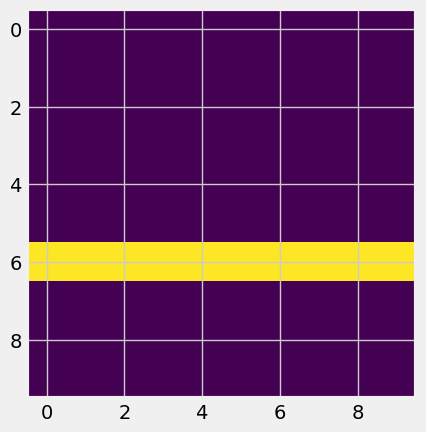

In [14]:
plt.imshow(images[0].squeeze())

In [15]:
modules = list(sbs_cnn1.model.named_modules())
modules

[('',
  Sequential(
    (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=160, out_features=10, bias=True)
    (relu2): ReLU()
    (fc2): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=160, out_features=10, bias=True)),
 ('relu2', ReLU()),
 ('fc2', Linear(in_features=10, out_features=3, bias=True))]

In [16]:
layer_names= {layer: name for name,layer in modules[1:]}

visulization= {}

#real hooking function 
def hook_fn(layer, inputs, outputs):
    name= layer_names[layer]
    visulization[name]= outputs.detach().cpu().numpy()


In [17]:
layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten',
  'fc1', 'relu2', 'fc2']

handles = {}
for name, layer in modules:
    if name in layers_to_hook:
        handles[name]=layer.register_forward_hook(hook_fn)

handles

{'conv1': <torch.utils.hooks.RemovableHandle at 0x2d0f7495c90>,
 'relu1': <torch.utils.hooks.RemovableHandle at 0x2d085235410>,
 'maxp1': <torch.utils.hooks.RemovableHandle at 0x2d0851db190>,
 'flatten': <torch.utils.hooks.RemovableHandle at 0x2d08523f490>,
 'fc1': <torch.utils.hooks.RemovableHandle at 0x2d0851d8d90>,
 'relu2': <torch.utils.hooks.RemovableHandle at 0x2d0851d9ad0>,
 'fc2': <torch.utils.hooks.RemovableHandle at 0x2d0851d8a50>}

In [18]:
images_batch, labels_path= next(iter(val_loader))
logits= sbs_cnn1.predict(images_batch)
visulization.keys()

dict_keys(['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

In [19]:
# # remove the hook after usages to avoid unnecessary operation 
for handle in handles.values():
    handle.remove()
handles= {} 

In [20]:
sbs_cnn1.attach_hooks(
    layers_to_hook= ['conv1', 'relu1', 'maxp1', 'flatten',
  'fc1', 'relu2', 'fc2']
)

AttributeError: 'StepByStep' object has no attribute 'handles'

In [ ]:
sbs_cnn1.visualization

{'conv1': None,
 'relu1': None,
 'maxp1': None,
 'flatten': None,
 'fc1': None,
 'relu2': None,
 'fc2': None}

In [ ]:
sbs_cnn1.handles

{'conv1': <torch.utils.hooks.RemovableHandle at 0x190da7bbc50>,
 'relu1': <torch.utils.hooks.RemovableHandle at 0x19082245a10>,
 'maxp1': <torch.utils.hooks.RemovableHandle at 0x19081fba310>,
 'flatten': <torch.utils.hooks.RemovableHandle at 0x190e7ca14d0>,
 'fc1': <torch.utils.hooks.RemovableHandle at 0x19081fb9f50>,
 'relu2': <torch.utils.hooks.RemovableHandle at 0x19081fba290>,
 'fc2': <torch.utils.hooks.RemovableHandle at 0x1908209f650>}

In [ ]:
#remove hook 
sbs_cnn1.remove_hooks()
print(sbs_cnn1.handles)
print(sbs_cnn1.visualization)

{}
{'conv1': None, 'relu1': None, 'maxp1': None, 'flatten': None, 'fc1': None, 'relu2': None, 'fc2': None}


In [ ]:
batch, lable = next(iter(val_loader))
print('predicted lables' , np.argmax(sbs_cnn1.predict(batch),axis=  1 )) #predicted lables 
print('real lables', lable)


predicted lables [2 2 0 0 0 0 0 2 0 1 0 1 2 1 2 0]
real lables tensor([2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0])


In [ ]:
# to get visualization attribute filled with values we still need to make prediction 
img_batch, lables_batch= next(iter(val_loader))
logits= sbs_cnn1.predict(img_batch)

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']
with plt.style.context('seaborn-v0_8-white'):
  fig = sbs_cnn1.visualize_outputs(featurizer_layers)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
sbs_cnn1.visualize_outputs

AttributeError: 'StepByStep' object has no attribute 'visualize_outputs'

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


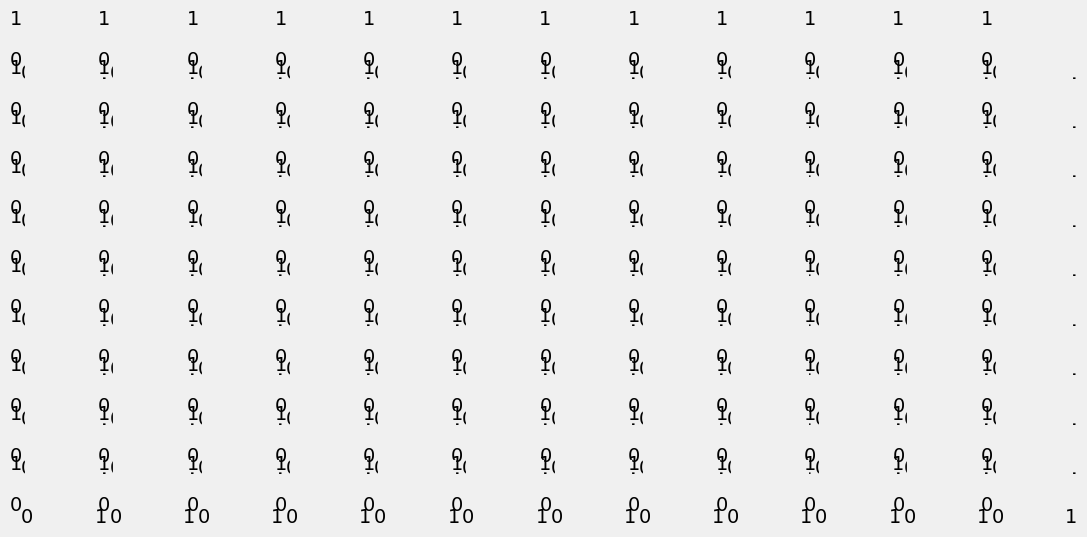

In [ ]:
fig, axes = plt.subplots(10,12, figsize=(12,6))

In [ ]:
axes

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Ax